In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import scipy.optimize as sco
import scipy.constants as c
from scipy.optimize import curve_fit as cf
import pandas as pd

import matplotlib.patches as mpatches

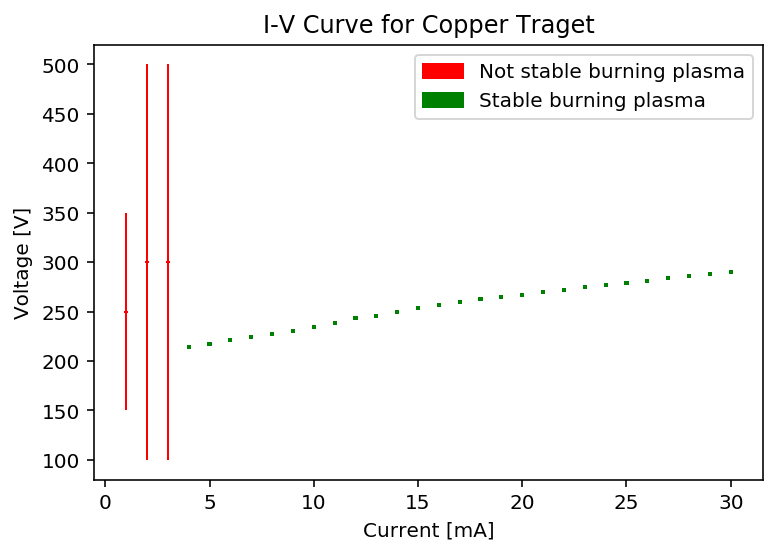

In [2]:
data=[]
data.append( pd.read_csv("20180307_JonasLehnenGuntherTuerk//I-V_curve.txt",delimiter="\t",skiprows=0 ))

for entry in data:
    I= entry.values[:,0]
    V= entry.values[:,1]
    dV=entry.values[:,2]
    stable= entry.values[:,3]
dI=[0.1 for x in range(len(I))]
    
fig, ax=plt.subplots(dpi=144)
for i in range(len(stable)):
    if stable[i]==1:
        ax.errorbar(I[i],V[i], yerr=dV[i], xerr=dI[i], color="r", linestyle="", linewidth=1)
    else:
        ax.errorbar(I[i],V[i], yerr=dV[i], xerr=dI[i], color="g", linestyle="", linewidth=2)
        
red   = mpatches.Patch(color='red',   label='Not stable burning plasma')
green = mpatches.Patch(color='green', label='Stable burning plasma')
plt.legend(handles=[red,green])

ax.set(xlabel="Current [mA]",ylabel="Voltage [V]",title="I-V Curve for Copper Traget")
fig.savefig("Plots/IVcurve.png")

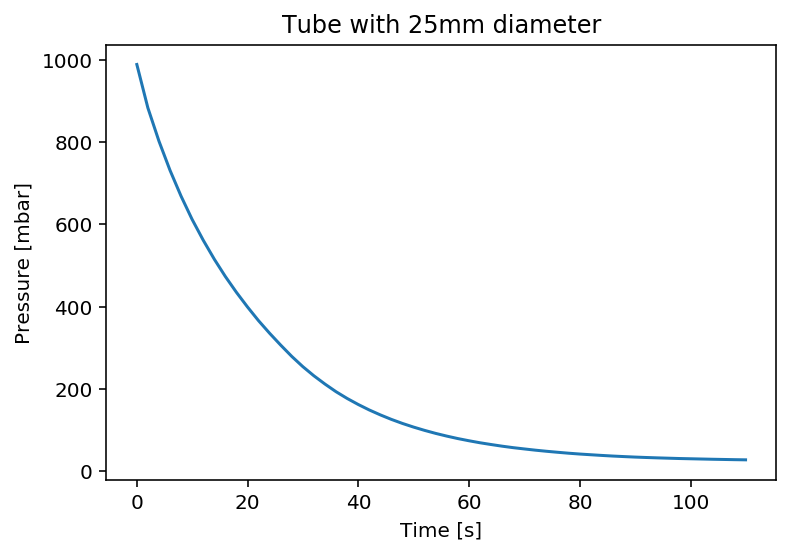

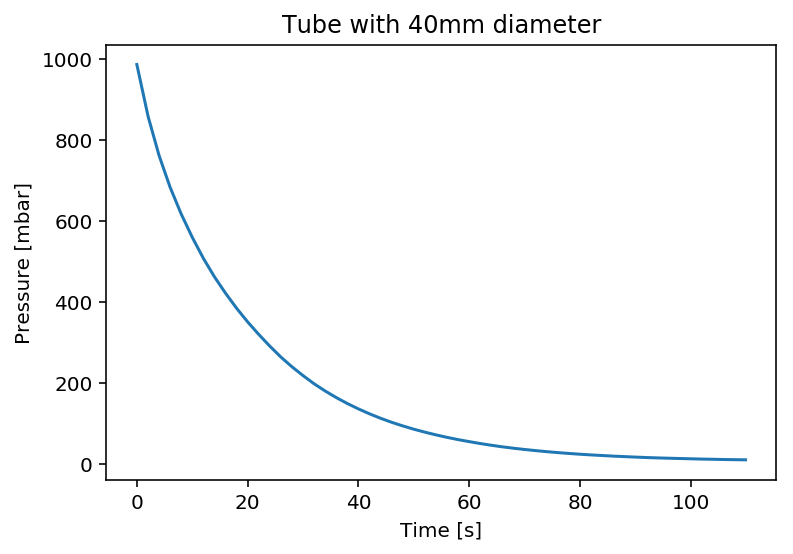

In [3]:
gamma=["25mm","40mm"]
t=[[],[],[]]
p=[[],[],[]]
for i in range(len(gamma)):
    name=gamma[i]
    test="20180307_JonasLehnenGuntherTuerk/20180307_JonasGunther_{}".format(name)
    data=[]
    data.append( pd.read_csv(test,delimiter="\t" ))
    
    for entry in data:
        t[i]= entry.values[:,0]
        p[i]= entry.values[:,3]
       
    run=0
    pStart=p[i][0]
    while pStart<p[i][run]+1: #Den konstanten Wert an Anfang weg bekommen
        run=run+1
    run=run-1
    t[i]=t[i]-t[i][run] # neue Zeiteichung
    t[i]=t[i][run:]
    p[i]=p[i][run:]
    
    count=0
    for j in t[i]: 
        if j<110.0:
            count=count+1
        else:
            break
    t[i]=t[i][:count]
    p[i]=p[i][:count]

    fig,ax=plt.subplots(dpi=144)
    ax.plot(t[i],p[i])
    ax.set(xlabel="Time [s]",ylabel="Pressure [mbar]", title="Tube with {} diameter".format(name))
    fig.savefig("Plots/{}.png".format(name))

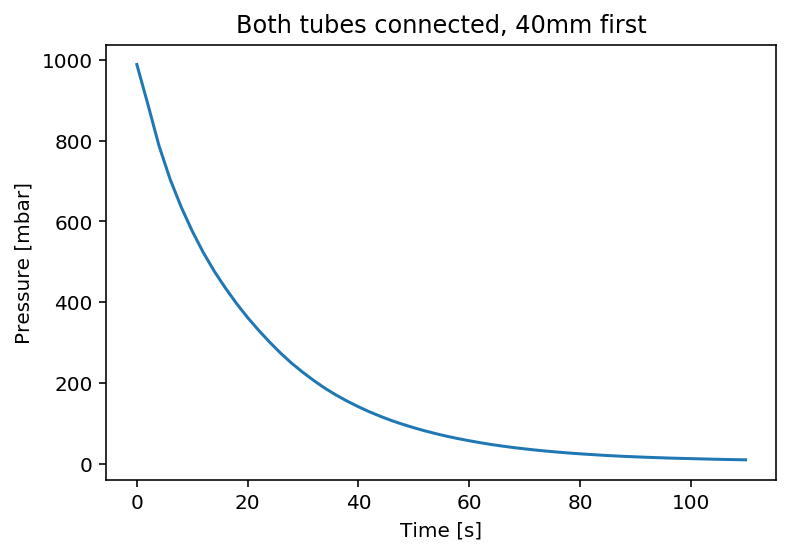

In [9]:
data=[]
data.append( pd.read_csv("20180307_JonasLehnenGuntherTuerk/20180307_JonasGunther_40mm25mm_40First",delimiter="\t",skiprows=11 ))
# skiprows=11 wegen komischen Zeitwerten am Anfang, kein Einfluss auf Start-Druck
for entry in data:
    t[2]= entry.values[:,0]
    p[2]= entry.values[:,3]    

run=0
pStart=p[2][0]
while pStart<p[2][run]+1: #Den konstanten Wert an Anfang weg bekommen
    run=run+1
run=run-1
t[2]=t[2]-t[2][run] # neue Zeiteichung
t[2]=t[2][run:]
p[2]=p[2][run:]

count=0
for j in t[i]: 
    if j<110.0:
        count=count+1
    else:
        break
t[i]=t[i][:count]
p[i]=p[i][:count]

fig,ax=plt.subplots(dpi=144)
ax.plot(t[2],p[2])
ax.set(xlabel="Time [s]",ylabel="Pressure [mbar]", title="Both tubes connected, 40mm first")
fig.savefig("Plots/BothTubes.png")

0.0 988.1
0.0 985.3
0.0 988.5


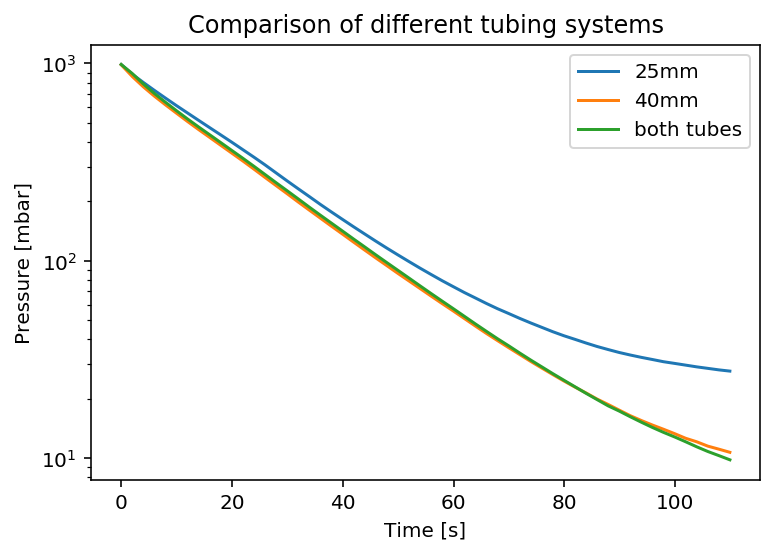

In [15]:
fig,ax=plt.subplots(dpi=144)
names=["25mm","40mm","both tubes"]

for i in range(3):
    print(t[i][0],p[i][0])
    ax.plot(t[i],p[i], label=names[i])

ax.set(xlabel="Time [s]",ylabel="Pressure [mbar]", title="Comparison of different tubing systems",
      yscale="log")
ax.legend();
fig.savefig("Plots/Comparison.png")

C:\Users\Gunther\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[  9.58695343e+02  -4.37034307e-02]


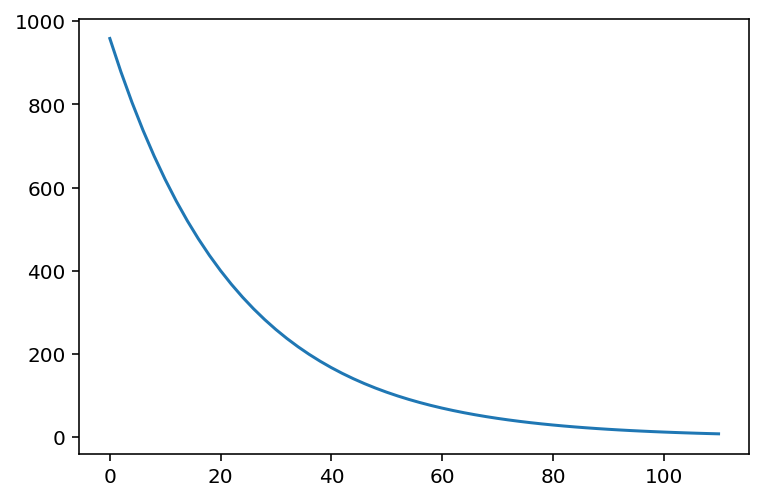

In [11]:
def exp(x,a,b):
    return a*np.exp(b*x)

popt,pcov=sco.curve_fit(exp,t[0],p[0], p0=[1000,-3])

fig,ax=plt.subplots(dpi=144)
ax.plot(t[0],exp(t[0],*popt))
print(popt)

In [19]:
def get_time(array,time):
    i=0
    for j in array:
        if j>time+1:
            break
        i=i+1
    return i

def get_p(array,p):
    i=0
    for j in array:
        if j<p:
            break
        i=i+1
    return i


V=30
Seff=[[],[],[]] # in l/s
for i in range(3):
    j0=get_time(t[i],5)
    j= get_time(t[i],60)
    
    #j0=get_p(p[i],980)
    #j= get_p(p[i],250)
    
    Seff[i].append( V/(t[i][j] - t[i][j0]) * np.log(p[i][j0] / t[i][j]))
    
print(Seff) # Je nach Wertepaaren komplett versch Seff'S... Anfangs super schnell -> viel Luft raus, später super langsam...



results=np.array([60/i[0] for i in Seff]) # Inverse von Seff zur C_i berechnung ## 60 für l/min
print(results)
# 25,40,both <- Inhalt der t,p,Seff Array's

equations=np.array([[1,1,0],[1,0,1],[1,1,1]])
x=np.linalg.solve(equations,results)
print(x)
lsg=[1/i for i in x]
print("Lösung: S= {}, C_25mm= {}, C_40mm= {}".format(lsg[0],lsg[1],lsg[2]))

print("S : ",-1/( 1/Seff[2][0]-1/Seff[2][0] - 1/Seff[1][0] ) /60 )
print("C_40: ",1/( 1/Seff[2][0] - 1/Seff[0][0] )/60)
print("C_25: ",1/( 1/Seff[2][0] - 1/Seff[1][0] )/60) ## Selbe Ergebnisse von analoger REchnung -.-'

[[1.3230733975089044], [1.2787143823098224], [1.2962490822160389]]
[ 45.34895805  46.92212806  46.28740018]
[ 45.98368593  -0.63472788   0.93844213]
Lösung: S= 0.021746843032335025, C_25mm= -1.575478292899957, C_40mm= 1.0655958089397612
S :  0.0213119063718
C_40:  1.06559580894
C_25:  -1.5754782929
